In [1]:
import numpy as np
import pandas as pd
import json

In [2]:
# Libraries that we cannot import for trading
import collections
import matplotlib.pyplot as plt
import re

import seaborn as sns
from IPython.display import display

In [3]:
SYMBOLS = ['BANANAS','PEARLS']
LOG_DIR = 'round1_logs/'

In [45]:
p = 'PEARLS'
b = 'BANANAS'

# DATA LOADING

In [4]:
def split_data_by_symbol(df):
    markets = dict()
    df_grouped = df.groupby("symbol")
    symbols = list(df_grouped.groups.keys())
    for s in symbols:
        markets[s] = df_grouped.get_group(s).reset_index(drop=True)
    return markets

def load_hist_quote_data(files):
    md = [pd.read_csv(f,sep=';') for f in files]
    md = pd.concat(md, ignore_index=True)
    md.drop(columns=['profit_and_loss'], inplace=True)
    rename_columns = {'product':'symbol', 'bid_price_1': 'bid', 'ask_price_1': 'ask', 
                      'bid_volume_1':'bid_sz', 'ask_volume_1': 'ask_sz', 
                      'bid_price_2':'bid_2','bid_volume_2':'bid_sz_2','ask_price_2':'ask_2','ask_volume_2':'ask_sz_2',
                      'bid_price_3':'bid_3','bid_volume_3':'bid_sz_3','ask_price_3':'ask_3','ask_volume_3':'ask_sz_3'}
    md.rename(columns=rename_columns, inplace=True)
    for i in [4, 5]:
        for col in ['bid','ask']:
            md[f'{col}_{i}'] = np.nan
            md[f'{col}_sz_{i}'] = np.nan

    markets = split_data_by_symbol(md)
    symbols = list(markets.keys())
    return markets


def load_hist_trade_data(files,hist_days):
    md = [pd.read_csv(f,sep=';') for f in files]
    for i in range(len(hist_days)):
        md[i]['day'] = hist_days[i]
    md = pd.concat(md, ignore_index=True)
    md.drop(columns=['buyer', 'seller'], inplace=True)
    markets = split_data_by_symbol(md)
    symbols = list(markets.keys())
    return markets


def combine_hist_quote_trades(hist_quotes, hist_trades):
    """ Join data frames together
    """
    for sym in SYMBOLS:
        quotes = hist_quotes[sym]
        trades = hist_trades[sym]
        # Join quote data to trades
        trades = trades.merge(quotes, how='left', on=['symbol','day','timestamp'])       

        # Summarize state by state trade data
        trades['notional'] = trades['price']*trades['quantity']
        trades_grp = trades.groupby(['symbol','day','timestamp']).agg({
            'quantity':'sum', 'notional':'sum',})
            # 'buy_vol':'sum', 'sell_vol':'sum','grey_vol':'sum'})
        trades_grp['vwap'] = trades_grp['notional']/trades_grp['quantity']
        trades_grp['trades'] = trades.groupby(['symbol','day','timestamp']).size()
        trades_grp = trades_grp.rename(columns={'quantity':'volume'}).drop(columns=['notional'])
        
        # Join trade data to quote
        quotes = quotes.merge(trades_grp.reset_index(), how='left')
        for col in ['volume', 'trades']:
            quotes[col].fillna(0, inplace=True)
        quotes.loc[quotes.vwap.isna(), 'vwap'] = quotes.loc[quotes.vwap.isna(), 'mid_price']
        
        # Update
        hist_quotes[sym] = quotes
        hist_trades[sym] = trades
    
    return hist_quotes, hist_trades

def load_hist_data(quote_files, trade_files, hist_days):
    hist_quotes = load_hist_quote_data(quote_files)
    hist_trades = load_hist_trade_data(trade_files, hist_days)
    
    hist_quotes, hist_trades = combine_hist_quote_trades(hist_quotes, hist_trades)
    return hist_quotes, hist_trades

In [5]:
def quote_levels_feature(quote):
    quote['bid_levels'] = 1
    quote['ask_levels'] = 1
    
    for i in range(2,6):
        quote.loc[quote[f'bid_{i}'].notna(), 'bid_levels'] += 1
        quote.loc[quote[f'ask_{i}'].notna(), 'ask_levels'] += 1
    
    return

def quote_weighted_px_full(quote, levels=5):
    notional = quote.bid_sz*quote.bid + quote.ask_sz*quote.ask
    size = quote.bid_sz + quote.ask_sz
    for i in range(2, min(quote['bid_levels'], levels)+1):
        notional += quote[f'bid_{i}']*quote[f'bid_sz_{i}']
        size += quote[f'bid_sz_{i}']
    for i in range(2, min(quote['ask_levels'], levels)+1):
        notional += quote[f'ask_{i}']*quote[f'ask_sz_{i}']
        size += quote[f'ask_sz_{i}']
    
    return notional/size

In [285]:
MOVING_WINDOW_TIMES = [5, 10, 25, 50]
HIST_PX_TIMES = [1, 5, 10, 20, 30, 50]
FUTURE_TIMES = [1, 5, 10, 25, 50, 100]

def quote_preprocess(md):
    """ Pre-computing additional columns for analyzing quote
    """
    # md['mid_price'] = (md.ask_price_1 + md.bid_price_1)/2
    if 'bid_levels' not in md.columns:
        quote_levels_feature(md)
    md['spread'] = md.ask - md.bid
    md['return'] = md['mid_price']/md['mid_price'].iloc[0] # % change in price since the beginning
    
    for t in MOVING_WINDOW_TIMES:
        md[f'mid_px_mavg{t}'] = md['mid_price'].rolling(t, min_periods=0).mean()
        md[f'mid_px_mavg{t}_norm'] = md[f'mid_px_mavg{t}']/md['mid_price']
        md[f'px_norm_mavg{t}'] = md['return'].rolling(t, min_periods=0).mean()
        
    # quote weighted average price
    quote_sz = md.bid_sz + md.ask_sz
    md['quote_wgt_px_top'] = (md.bid_sz*md.bid + md.ask_sz*md.ask)/quote_sz
    md['fair_v1'] = md.apply(quote_weighted_px_full, axis=1)
    
    for t in HIST_PX_TIMES:
        # Price move since the past
        md[f'px_move_{t}'] = md.mid_price-md.mid_price.shift(t)
        md[f'px_move_{t}'].fillna(0, inplace=True)
        md[f'px_move_{t}_norm'] = md[f'px_move_{t}']/md['mid_price']
        
        # log return
        md[f'log_return_{t}'] = np.log(md.mid_price)-np.log(md.mid_price.shift(t))
        md[f'log_return_{t}'].fillna(1, inplace=True)
    # Volume    
    for t in MOVING_WINDOW_TIMES:
        md[f'volume_{t}'] = md['volume'].rolling(t, min_periods=0).sum()
        
    md = md.copy()

    md['quote_imb'] = md.bid_sz/quote_sz
    md['levels_imb'] = md.bid_levels-md.ask_levels # Positive implies people are preparing for quote to move in
    
    ############# Future
    # Future prices
    for t in FUTURE_TIMES:
        # Future - present
        # Mid to mid, bid to mid, ask to mid
        md[f'fpx_{t}'] = md.mid_price.shift(-t).fillna(method='ffill') - md.mid_price
        md[f'fpx_bid_{t}'] = md.mid_price.shift(-t).fillna(method='ffill') - md.bid
        md[f'fpx_ask_{t}'] = md.mid_price.shift(-t).fillna(method='ffill') - md.ask
    for t in FUTURE_TIMES:
        md[f'fpx_move_{t}'] = np.sign(md[f'fpx_{t}'])
        md[f'fpx_bid_move_{t}'] = md[f'fpx_bid_{t}'] > 0
        md[f'fpx_ask_move_{t}'] = md[f'fpx_ask_{t}'] <= 0
    md['fvolume'] = md['volume'].shift(-1)
    for t in MOVING_WINDOW_TIMES:
        md[f'fvolume_{t}'] = md[f'volume_{t}'].shift(-t)
    md = md.copy()
        
    # Features
    quote['total_bid_sz'] = quote[['bid_sz','bid_sz_2','bid_sz_3','bid_sz_4','bid_sz_5']].sum(axis=1)
    quote['max_bid_sz'] = quote[['bid_sz','bid_sz_2','bid_sz_3','bid_sz_4','bid_sz_5']].max(axis=1)
    quote['total_ask_sz'] = quote[['ask_sz','ask_sz_2','ask_sz_3','ask_sz_4','ask_sz_5']].sum(axis=1)
    quote['max_ask_sz'] = quote[['ask_sz','ask_sz_2','ask_sz_3','ask_sz_4','ask_sz_5']].max(axis=1)
    
    md['bid_sz_mavg'] = md['bid_sz'].cumsum()/(1+md['timestamp']/100)
    md['ask_sz_mavg'] = md['ask_sz'].cumsum()/(1+md['timestamp']/100)
       
    for v in [1]:
        md[f'dist_fair_v{v}'] = md[f'fair_v{v}']-md['mid_price']
        md[f'dist_fair_v{v}_norm'] = md[f'dist_fair_v{v}']/md['mid_price']
        
        md[f'dist_fair_v{v}_bid'] = md[f'fair_v{v}']-md['bid'] # expected to be positive
        md[f'dist_fair_v{v}_ask'] = md[f'fair_v{v}']-md['ask'] # expected to be negative
    
    md['bid_improve'] = md['bid'] > md['bid'].shift(1)
    md['bid_revert'] = md['bid'] < md['bid'].shift(1)
    md['ask_improve'] = md['ask'] < md['ask'].shift(1)
    md['ask_revert'] = md['ask'] > md['ask'].shift(1)
    
    return md

In [286]:
def hist_data_summary(hist_quotes, hist_trades):
    for sym in SYMBOLS:
        print(sym)
        quote = hist_quotes[sym]
        quote_summary = quote.agg({
            'spread':['mean','std'], 'mid_price': ['mean','std'], 
            'volume':['sum', 'mean'], 'trades':['sum', 'mean'],
            'bid_sz': 'mean', 'ask_sz':'mean', 
            'bid_levels':'mean', 'ask_levels':'mean',
            'bid_sz_2':'mean', 'ask_sz_2':'mean',
            'bid_sz_3':'mean', 'ask_sz_3':'mean',
        }).round(2)
        display(quote_summary)

In [8]:
data_dir = 'hist_data/island-data-bottle-round-1/'
hist_days = [-2, -1, 0]
quote_files = [f'{data_dir}prices_round_1_day_{i}.csv' for i in hist_days]
trade_files = [f'{data_dir}trades_round_1_day_{i}_nn.csv' for i in hist_days]

hist_quotes, hist_trades = load_hist_data(quote_files, trade_files, hist_days)
for sym in SYMBOLS:
    hist_quotes[sym] = quote_preprocess(hist_quotes[sym])

In [10]:
hist_data_summary(hist_quotes, hist_trades)

BANANAS


,spread,mid_price,volume,trades,bid_sz,ask_sz,bid_levels,ask_levels,bid_sz_2,ask_sz_2,bid_sz_3,ask_sz_3
mean,5.29,4929.88,0.78,0.29,17.55,17.98,1.41,1.4,23.27,22.43,24.5,24.28
std,1.90,38.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sum,NaN,NaN,23545.00,8551.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


PEARLS


,spread,mid_price,volume,trades,bid_sz,ask_sz,bid_levels,ask_levels,bid_sz_2,ask_sz_2,bid_sz_3,ask_sz_3
mean,6.77,10000.0,0.51,0.24,8.22,8.21,1.92,1.92,19.71,19.67,23.1,23.11
std,2.48,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sum,NaN,NaN,15227.00,7235.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# TRADING LOG LOADING

In [28]:
def read_trading_logs(file):
    # Load in jsons for trading states and sent orders
    state_regex = re.compile(r"(\d+) (\{.*\})")
    # orders_depth_regex = re.compile(r"(\d+) ORDER_DEPTHS (\{.*\})")
    # market_trades_regex = re.compile(r"(\d+) MARKET_TRADES (\{.*\})")
    # own_trades_regex = re.compile(r"(\d+) OWN_TRADES (\{.*\})")
    # position_regex = re.compile(r"(\d+) POSITION (\{.*\})")
    orders_regex = re.compile(r"(\d+) SENT_ORDERS (\{.*\})")
    empty_regex = re.compile(r"(\d+) \$")
    
    trading_states = []
    sent_orders = []
    with open(file, "r") as fp:
        lines = fp.readlines()
        for l in lines:
            match = state_regex.match(l)
            if match:
                trading_states.append(match.group(2))
                continue
            match = orders_regex.match(l)
            if match:
                sent = json.loads(match.group(2))
                sent['timestamp'] = int(match.group(1))
                sent_orders.append(sent)
                continue
            match = empty_regex.match(l)
            if match:
                trading_states.append(match.group(1))
        
    return trading_states, sent_orders

def process_trading_state_jsons(trading_states):
    positions = []
    market_trades = []
    latest_trade_timestamp = collections.defaultdict(int)
    own_trades = []
    order_depths = []
    
    listings = json.loads(trading_states[0])["listings"]
    for l in listings:
        # Dummy position
        positions.append({"timestamp": -1, "symbol": l, "position": 0})
    
    for t in trading_states:
        state = json.loads(t)
        if type(state) == int:
            insert_empty_state(state, listings, positions)
        else:
            extract_position(positions, state)
            extract_new_trades(market_trades, latest_trade_timestamp, state)
            extract_own_trades(own_trades, state)
            extract_order_book(order_depths, state)
            
    positions = pd.DataFrame(positions)
    market_trades = pd.DataFrame(market_trades)
    if len(own_trades) == 0:
        own_trades.append({"timestamp": -1, "symbol": l, "price": np.nan, "quantity": 0, "buyer": "DUMMY", "seller": 0})
    own_trades = pd.DataFrame(own_trades)
    order_depths = pd.DataFrame(order_depths)
    
    return positions, market_trades, own_trades, order_depths

def insert_empty_state(timestamp, listings, *args):
    # Insert timestamp corresponding to the empty state - these are to be forward filled
    for data in args:
        for l in listings:
            data.append({"timestamp": timestamp, "symbol": l})
    return

def extract_position(positions, state):
    pos = state['position']
    for p in pos:
        positions.append({"timestamp": state['timestamp'], "symbol": p, "position": pos[p]})
    for p in SYMBOLS:
        if p not in pos:
            positions.append({"timestamp": state['timestamp'], "symbol": p, "position": 0})
    return

def extract_new_trades(market_trades, latest_trade_timestamp, state):
    time = state['timestamp']
    for sym in state['market_trades']:
        for t in state['market_trades'][sym]:
            if t['timestamp'] == time-100:
                market_trades.append(t)
            elif t['timestamp'] == time:
                print("Found same timestamp trade")
    return

def extract_own_trades(own_trades, state):
    time = state['timestamp']
    for sym in state['own_trades']:
        for t in state['own_trades'][sym]:
            if t['timestamp'] == time-100:
                own_trades.append(t)
            elif t['timestamp'] == time:
                print("Found same timestamp trade")
    return

def extract_order_book(order_depths, state):
    time = state['timestamp']
    for sym in state['order_depths']:
        quote = create_quote(time, sym, state['order_depths'][sym])
        order_depths.append(quote)
    return

def create_quote(time, sym, order_depths):
    quote = {'timestamp': time, 'symbol': sym}
    
    # Buy quotes
    quote['bid_levels'] = len(order_depths['buy_orders'])
    for i, px in enumerate(sorted(order_depths['buy_orders'], key=lambda x: float(x), reverse=True)):
        # Highest to lowest
        quote[f'bid_{i+1}'] = float(px)
        quote[f'bid_sz_{i+1}'] = order_depths["buy_orders"][px]
    for i in range(5, 1, -1):
        if f'bid_{i}' in quote:
            break
        else:
            quote[f'bid_{i}'] = np.nan
            quote[f'bid_sz_{i}'] = np.nan
    
    # Sell quotes
    quote['ask_levels'] = len(order_depths['sell_orders'])
    for i, px in enumerate(sorted(order_depths['sell_orders'], key=lambda x: float(x))):
        quote[f'ask_{i+1}'] = float(px)
        quote[f'ask_sz_{i+1}'] = np.abs(order_depths["sell_orders"][px])
    for i in range(5, 1, -1):
        if f'ask_{i}' in quote:
            break
        else:
            quote[f'ask_{i}'] = np.nan
            quote[f'ask_sz_{i}'] = np.nan
        
    return quote

def process_order_depths(order_depths):
    order_depths.rename(columns={'bid_1': 'bid', 'ask_1': 'ask', 'bid_sz_1': 'bid_sz', 'ask_sz_1': 'ask_sz'}, inplace=True)
    order_depths['mid_price'] = (order_depths['bid']+order_depths['ask'])/2
    nbbo = order_depths[['timestamp','symbol','bid','ask','bid_sz','ask_sz', 'mid_price']].copy()

    return nbbo

def process_market_trades(market_trades):
    """ Processing of dataframe for market_trades
    """
    market_trades.drop(columns=['buyer', 'seller'], inplace=True)
    return

def process_own_trades(own_trades):
    """ Processing of dataframe for own_trades
    """ 
    # Side refers to side of algo
    own_trades['side'] = own_trades.apply(lambda x: 1 if x['buyer'] else -1, axis=1)
    own_trades.drop(columns=['buyer', 'seller'], inplace=True)
    return

def process_sent_orders_json(sent_orders):
    if len(sent_orders) == 0:
        return pd.DataFrame(columns = ['symbol', 'timestamp', 'price', 'quantity', 'side'])
    df = []
    for t in sent_orders:
        time = t['timestamp']
        for s in t:
            if s != 'timestamp' and t[s]:
                for order in t[s]:
                    order['timestamp'] = time
                    df.append(order)
        
    df = pd.DataFrame(df)
    return df

def augment_trade_data(trades):
    """ Making a guess to the sides of the trades based distance to mid price of previous quote
    Experimental - NOT SURE IF THIS IS GOING TO BE HELPFUL
    """
    bid_dist = trades['price'] - trades['bid']
    ask_dist = trades['ask'] - trades['price']
    trades['side'] = np.sign(ask_dist - bid_dist)
    return

def combine_quote_trades(quote, trades):
    # Aggregate timestamp data of trades
    trades['notional'] = trades['price']*trades['quantity']
    # trades['buy_vol'] = trades.apply(lambda x: x['quantity'] if x['side'] == 1 else 0, axis=1)
    # trades['sell_vol'] = trades.apply(lambda x: x['quantity'] if x['side'] == -1 else 0, axis=1)
    # trades['grey_vol'] = trades.apply(lambda x: x['quantity'] if x['side'] == 0 else 0, axis=1)
    
    # Trades are aligned to happen after the order depth that we see in the market
    trades['timestamp'] = trades['timestamp'] + 100
    trades_grouped = trades.groupby(['symbol', 'timestamp']).agg({'quantity':'sum', 'notional':'sum'})
    trades_grouped['vwap'] = trades_grouped['notional']/trades_grouped['quantity']
    trades_grouped['trades'] = trades.groupby(['symbol', 'timestamp']).size()
    
    trades_grouped = trades_grouped.rename(columns={'quantity':'volume'}).drop(columns=['notional'])
    quote = quote.merge(trades_grouped.reset_index(), how='left')
    for col in ['volume', 'trades']:
        quote[col].fillna(0, inplace=True)
    
    quote.loc[quote.vwap.isna(), 'vwap'] = quote.loc[quote.vwap.isna(), 'mid_price']
    return quote

def fill_active(x):
    if x['side'] == 1:
        # Buy
        return x['price'] >= x['ask']
    else:
        return x['price'] <= x['bid']

def combine_orders_fills(orders, fills):
    """ Combine orders sent with fills that the order got in the market
    """
    if orders.empty:
        return orders
    fills['active'] = fills.apply(fill_active, axis=1)
    fills['active_qty'] = fills['active']*fills['quantity']
    fills['passive_qty'] = (~fills['active'])*fills['quantity']

    fill_data = fills.groupby(['symbol','timestamp','price', 'side'])[['quantity','active_qty','passive_qty']].sum()
    fill_data.reset_index(inplace=True)
    fill_data.rename(columns={'quantity': 'fill_qty'}, inplace=True)
    orders = orders.merge(fill_data, how='left', on=['symbol','timestamp','price','side'])
    for col in ['fill_qty','active_qty','passive_qty']:
        orders[col].fillna(0, inplace=True)
    orders['fill_pct'] = np.abs(orders['fill_qty']/orders['quantity'])
    
    return orders

# PnL, Position, Volume Traded, Notional Traded, VWAP
def trading_performance(positions, own_trades, quote):
    positions = positions.merge(quote[['timestamp','symbol','mid_price']], on=['symbol','timestamp']) # Add mid price
    own_trades['trades'] = 1
    own_trades['notional'] = own_trades['price']*own_trades['quantity']
    own_trades.rename(columns={'quantity':'qty'},inplace=True)
    vol_cols = []
    for col in ['qty','notional','trades']:
        own_trades[f'buy_{col}'] = own_trades[col]
        own_trades[f'sell_{col}'] = own_trades[col]
        own_trades.loc[own_trades['side'] == -1, f'buy_{col}'] = 0
        own_trades.loc[own_trades['side'] == 1, f'sell_{col}'] = 0
        vol_cols += [col, f'buy_{col}',f'sell_{col}']
    own_trades_g = own_trades.groupby(['symbol','timestamp'])[vol_cols].sum()

    positions = positions.merge(own_trades_g.reset_index(), how='left', on=['symbol','timestamp'])
    for col in vol_cols:
        positions[col].fillna(0, inplace=True)
        positions[f'total_{col}'] = positions.groupby(['symbol'])[col].cumsum()
    positions['pnl'] = (positions['total_sell_notional']-positions['total_buy_notional']) \
            - positions['mid_price']*(positions['total_sell_qty']-positions['total_buy_qty'])

    positions = positions.copy()
    return positions

def load_data_from_log(file, by_symbol=True):
    trading_states, sent_orders = read_trading_logs(file)
    positions, market_trades, own_trades, order_depths = process_trading_state_jsons(trading_states)
    quote = process_order_depths(order_depths)
    process_market_trades(market_trades)
    process_own_trades(own_trades)
    orders = process_sent_orders_json(sent_orders)
    
    # Joining actions to state
    market_trades = market_trades.merge(quote, how='left', on=['symbol','timestamp',])
    augment_trade_data(market_trades)
    
    own_trades = own_trades.merge(quote, how='left', on=['symbol','timestamp','symbol'])
    orders = orders.merge(quote, how='left', on=['symbol','timestamp'])
    orders = combine_orders_fills(orders, own_trades)
    quote = combine_quote_trades(quote, market_trades.copy())
    order_depths = combine_quote_trades(order_depths, market_trades.copy())
    positions = trading_performance(positions, own_trades.copy(), quote) 
    
    dfs = {}
    dfs['orders'] = orders
    dfs['positions'] = positions
    dfs['order_depths'] = order_depths
    dfs['quote'] = quote
    dfs['market_trades'] = market_trades
    dfs['own_trades'] = own_trades
    
    if by_symbol:
        for table in dfs:
            dfs[table] = split_data_by_symbol(dfs[table])    
    return dfs

In [98]:
fig_size = (6,3)

def plot_intraday(dfs, col):
    f, ax = plt.subplots(figsize=fig_size)
    for product in dfs:
        ax.plot("timestamp", col, data=dfs[product], label=product)
    ax.set_xlabel("Time")
    ax.set_ylabel(col)
    ax.legend()
    return

def plot_quote(md, sym):
    f, ax = plt.subplots(figsize=fig_size)
    ax.plot("timestamp", "bid", data=md, color="red")
    ax.plot("timestamp", "ask", data=md, color="blue")
    ax.set_xlabel("Time")
    ax.set_ylabel("Price (Seashells)")
    ax.set_title(sym)
    return

def trading_simulation_summary(dfs):
    total_pnl = 0
    for sym in SYMBOLS:
        trade_perf = dfs['positions'][sym].iloc[-1]
        pnl = trade_perf['pnl']
        total_pnl += pnl
        market_volume = dfs['market_trades'][sym]['quantity'].sum()
        trade_count = trade_perf['total_trades']
        trade_volume = trade_perf['total_qty']

        print("""{}: PnL={} | Trades={} | MarketVol={} | Volume Filled={} | POV={:.2} | PnL/Share={:.4}""".format(sym, \
            pnl, trade_count, market_volume, trade_volume,trade_volume/(market_volume+trade_volume), pnl/trade_volume))
    print("Total PnL={}".format(total_pnl))
    plot_intraday(dfs['positions'], 'pnl')
    plot_intraday(dfs['positions'], 'position')

BANANAS: PnL=1597.0 | Trades=273.0 | MarketVol=371 | Volume Filled=948.0 | POV=0.72 | PnL/Share=1.685
PEARLS: PnL=1437.0 | Trades=316.0 | MarketVol=265 | Volume Filled=879.0 | POV=0.77 | PnL/Share=1.635
Total PnL=3034.0


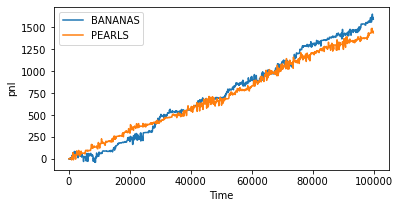

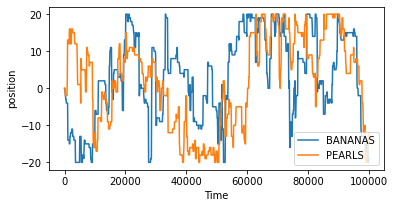

In [352]:
file_name = "aedb0499-3a1a-4a57-8154-e0fdb7994100"
file_name = "2777f49e-a424-4993-920b-0ba3d589bc91"
# file_name = "e5e0e0d6-31fb-48b4-8a65-07cc8922bbc0"
file_name = "404740c3-219c-4925-bb55-ed078510018d"
file_name = "17110e00-a2bb-4fdc-932a-e88dbe5eedd5"
# file_name = "4cb06b59-8b9f-496b-9aec-716074b520d2"
# file_name = "abe02eb0-d850-4da0-8dd0-fecdea60d8f8"
# file_name = "6c6dd40c-8a3c-446a-bd06-47de5391459c"
file_name = "ebf249fc-a236-4d3e-bc6e-3f24ada9dd09"
file_name = "97d3dc75-bdf2-4639-9c2c-c952b1bfe190" # baseline
file_name = "0569884f-ec0f-4b3b-9f37-fae1d4e917bf" # change theo offest
file_name = "8ac45266-eaa7-457e-b46f-1a2d5b9740e0" # increase take size
# file_name = "61d23070-68ce-4b08-bdb6-8eb199b3f898" # plus 1

log_file = LOG_DIR + file_name + '.log'
dfs = load_data_from_log(log_file, True)
trading_simulation_summary(dfs)

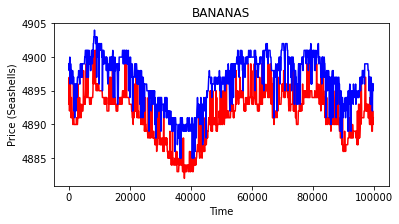

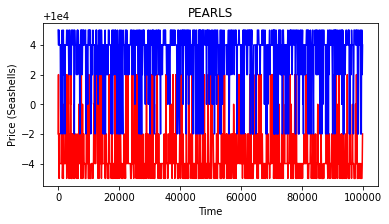

In [251]:
for s in SYMBOLS:
    plot_quote(dfs['quote'][s], s)

In [48]:
# Ensure that orders are not crossing
orders = dfs['orders'][b]
buy_orders = orders.loc[orders.side == 1].copy()
sell_orders = orders.loc[orders.side == -1].copy()

orders_sent = buy_orders.merge(sell_orders[['symbol','timestamp','price','quantity','fill_qty','note']], on=['symbol','timestamp'], suffixes=("_buy","_sell"))
orders_sent.loc[orders_sent['price_buy'] >= orders_sent['price_sell']]

,note_buy,price_buy,quantity_buy,side,symbol,timestamp,bid,ask,bid_sz,ask_sz,mid_price,fill_qty_buy,active_qty,passive_qty,fill_pct,price_sell,quantity_sell,fill_qty_sell,note_sell


# Market Trade Analysis
- Trying to understand what causes algo to miss market trades

In [235]:
def order_analysis(orders):
    orders['px_bid_dist'] = orders['price'] - orders['bid']
    orders['px_ask_dist'] = orders['price'] - orders['ask']
    orders['filled'] = orders['fill_qty'] > 0
    
    for t in FUTURE_TIMES:
        orders[f'toxicity_{t}'] = orders['side']*(orders[f'fpx_{t}']+orders['mid_price']-orders['price'])
        orders[f'pnl_{t}'] = orders['fill_qty']*orders[f'toxicity_{t}']
        orders[f'fill_revert_{t}'] = np.sign(orders[f'pnl_{t}'])
        orders[f'spread_capture_{t}'] = orders[f'toxicity_{t}']/orders['spread']
    
    return

toxicity_labels, reversion_labels = [], []
for t in FUTURE_TIMES:
    toxicity_labels.append(f'toxicity_{t}')
    reversion_labels.append(f'fill_revert_{t}')

In [353]:
market_trades = dfs['market_trades'][p]
orders = dfs['orders'][p]
quote = dfs['order_depths'][p].copy()

In [358]:
orders_cols = ['note', 'price', 'quantity', 'side', 'symbol', 'timestamp','fill_qty']
fills = orders.loc[orders.fill_qty > 0]
fills = filled_orders.merge(quote_preprocess(quote), how='left',on=['symbol','timestamp'], suffixes=('','_q'))
buy_fills = fills.loc[fills.side == 1].copy()
sell_fills = fills.loc[fills.side == -1].copy()
# order_analysis(filled_orders)
missed_fills = orders[orders_cols].merge(market_trades, on=['symbol','timestamp'], suffixes=('_algo','_mkt'))
missed_fills = missed_fills.merge(quote_preprocess(quote), how='left',on=['symbol','timestamp'], suffixes=('','_q'))

missed_buy_fills = missed_fills.loc[(missed_fills.side_algo == 1) & (missed_fills.price_algo >= missed_fills.price_mkt)].copy()
missed_sell_fills = missed_fills.loc[(missed_fills.side_algo == -1) & (missed_fills.price_algo <= missed_fills.price_mkt)].copy()

In [356]:
fills['fill_qty'].describe()

count    385.000000
mean       2.774026
std        2.597746
min        1.000000
25%        1.000000
50%        2.000000
75%        4.000000
max       13.000000
Name: fill_qty, dtype: float64

In [366]:
missed_fills[missed_fills['quantity_mkt'] >= 2][cols].head(20)

,note,price_algo,quantity_algo,side_algo,symbol,timestamp,fill_qty,price_mkt,quantity_mkt,bid,ask,bid_sz,ask_sz,mid_price,max_bid_sz,max_ask_sz,total_bid_sz,total_ask_sz
0,P0,9999,4,1,PEARLS,2500,0.0,10002.0,4,9998.0,10004.0,3,2,10001.0,21.0,21.0,26.0,23.0
1,P2,10002,36,-1,PEARLS,2500,0.0,10002.0,4,9998.0,10004.0,3,2,10001.0,21.0,21.0,26.0,23.0
2,X,10002,3,-1,PEARLS,2600,1.0,10002.0,4,10002.0,10004.0,1,1,10003.0,29.0,29.0,31.0,30.0
3,P0,9999,4,1,PEARLS,2600,0.0,10002.0,4,10002.0,10004.0,1,1,10003.0,29.0,29.0,31.0,30.0
4,P2,10002,33,-1,PEARLS,2600,1.0,10002.0,4,10002.0,10004.0,1,1,10003.0,29.0,29.0,31.0,30.0
7,P0,9999,5,1,PEARLS,3100,0.0,10002.0,5,9998.0,10004.0,5,1,10001.0,27.0,27.0,33.0,28.0
8,P2,10002,35,-1,PEARLS,3100,0.0,10002.0,5,9998.0,10004.0,5,1,10001.0,27.0,27.0,33.0,28.0
9,X,10002,4,-1,PEARLS,3200,2.0,10002.0,5,10002.0,10005.0,2,24,10003.5,24.0,24.0,26.0,24.0
10,P0,9999,5,1,PEARLS,3200,0.0,10002.0,5,10002.0,10005.0,2,24,10003.5,24.0,24.0,26.0,24.0
11,P2,10002,31,-1,PEARLS,3200,2.0,10002.0,5,10002.0,10005.0,2,24,10003.5,24.0,24.0,26.0,24.0


In [363]:
cols = ['note', 'price_algo', 'quantity_algo', 'side_algo', 'symbol', 'timestamp',
       'fill_qty', 'price_mkt', 'quantity_mkt', 'bid', 'ask', 'bid_sz',
       'ask_sz', 'mid_price', 'max_bid_sz','max_ask_sz','total_bid_sz','total_ask_sz']
fill_cols = ['note', 'price', 'quantity', 'side', 'symbol', 'timestamp', 'bid',
       'ask', 'bid_sz', 'ask_sz', 'mid_price', 'fill_qty','max_bid_sz','max_ask_sz','total_bid_sz','total_ask_sz']

In [336]:
buy_fills['better_mid'] = buy_fills['price'] >= buy_fills['mid_price']-1

In [338]:
buy_fills.loc[(buy_fills.quantity >= 20) & (buy_fills.note == 'P2')][['better_mid', 'fair_v1']+fill_cols]

,better_mid,fair_v1,note,price,quantity,side,symbol,timestamp,bid,ask,bid_sz,ask_sz,mid_price,fill_qty,max_bid_sz,max_ask_sz,total_bid_sz,total_ask_sz
45,True,9999.882353,P2,9998,33,1,PEARLS,10700,9995.0,9998.0,24,3,9996.5,3.0,24.0,24.0,24.0,27.0
49,True,9999.724138,P2,9998,20,1,PEARLS,12100,9996.0,9998.0,2,8,9997.0,8.0,23.0,23.0,25.0,33.0
61,True,9999.968254,P2,9998,29,1,PEARLS,14800,9996.0,9998.0,1,1,9997.0,1.0,30.0,30.0,31.0,32.0
63,True,9999.953488,P2,9998,28,1,PEARLS,15100,9996.0,9998.0,1,1,9997.0,1.0,20.0,20.0,21.0,22.0
67,False,10000.000000,P2,9998,20,1,PEARLS,16300,9996.0,10004.0,1,1,10000.0,2.0,21.0,21.0,22.0,22.0
135,True,9999.882353,P2,9998,22,1,PEARLS,31600,9995.0,9998.0,24,3,9996.5,3.0,24.0,24.0,24.0,27.0
136,True,10000.098361,P2,9998,23,1,PEARLS,31700,9995.0,10002.0,29,3,9998.5,3.0,29.0,29.0,29.0,32.0
148,False,10000.000000,P2,9998,28,1,PEARLS,37300,9996.0,10004.0,1,1,10000.0,3.0,22.0,22.0,23.0,23.0
156,True,9999.904762,P2,9998,33,1,PEARLS,39100,9996.0,9998.0,2,3,9997.0,3.0,28.0,28.0,30.0,33.0
161,True,9999.959184,P2,9998,22,1,PEARLS,39800,9996.0,9998.0,2,1,9997.0,1.0,22.0,22.0,24.0,25.0


In [342]:
missed_buy_fills.loc[missed_buy_fills['quantity_algo'] >= 20][['fair_v1'] + cols]

,fair_v1,note,price_algo,quantity_algo,side,symbol,timestamp,fill_qty,price_mkt,quantity_mkt,bid,ask,bid_sz,ask_sz,mid_price,max_bid_sz,max_ask_sz,total_bid_sz,total_ask_sz
43,10000.000000,P2,9998,26,1,PEARLS,31500,0.0,9998.0,1,9996.0,10004.0,1,1,10000.0,21.0,21.0,22.0,22.0
57,10000.000000,P2,9998,37,1,PEARLS,47300,0.0,9998.0,1,9995.0,10005.0,21,21,10000.0,21.0,21.0,21.0,21.0
58,9999.725490,P1,9999,37,1,PEARLS,47400,0.0,9998.0,1,9998.0,10005.0,7,22,10001.5,22.0,22.0,29.0,22.0
63,10000.000000,P2,9998,23,1,PEARLS,51900,0.0,9998.0,1,9996.0,10004.0,2,2,10000.0,26.0,26.0,28.0,28.0
73,10000.000000,P2,9998,30,1,PEARLS,55800,0.0,9998.0,4,9996.0,10004.0,1,1,10000.0,25.0,25.0,26.0,26.0
74,10000.000000,P2,9998,30,1,PEARLS,55900,0.0,9998.0,4,9995.0,10005.0,20,20,10000.0,20.0,20.0,20.0,20.0
76,10000.064516,P2,9998,25,1,PEARLS,56600,0.0,9998.0,1,9996.0,10002.0,2,2,9999.0,28.0,28.0,30.0,32.0
77,9999.830508,P1,9999,25,1,PEARLS,56700,0.0,9998.0,1,9998.0,10005.0,5,27,10001.5,27.0,27.0,32.0,27.0
78,10000.370370,P2,9998,25,1,PEARLS,57000,0.0,9998.0,1,9996.0,10002.0,2,10,9999.0,20.0,20.0,22.0,32.0
79,9999.777778,P1,9999,25,1,PEARLS,57100,0.0,9998.0,1,9998.0,10005.0,6,24,10001.5,24.0,24.0,30.0,24.0


In [179]:
missed_fills.loc[missed_fills.note == 'P1']

,note,price_algo,quantity_algo,side,symbol,timestamp,fill_qty,price_mkt,quantity_mkt,bid,ask,bid_sz,ask_sz,mid_price
18,P1,4899,31,-1,BANANAS,15100,0.0,4898.0,3,4894.0,4900.0,21,1,4897.0
48,P1,4887,15,1,BANANAS,33000,15.0,4887.0,1,4886.0,4892.0,2,28,4889.0
61,P1,4890,22,1,BANANAS,45700,0.0,4890.0,7,4889.0,4895.0,2,23,4892.0
62,P1,4891,22,1,BANANAS,45800,0.0,4891.0,1,4890.0,4896.0,2,32,4893.0
85,P1,4895,6,1,BANANAS,59800,6.0,4895.0,12,4894.0,4900.0,11,24,4897.0
99,P1,4899,30,-1,BANANAS,66200,0.0,4898.0,5,4894.0,4900.0,23,1,4897.0
138,P1,4895,19,-1,BANANAS,86100,0.0,4895.0,1,4890.0,4896.0,27,28,4893.0


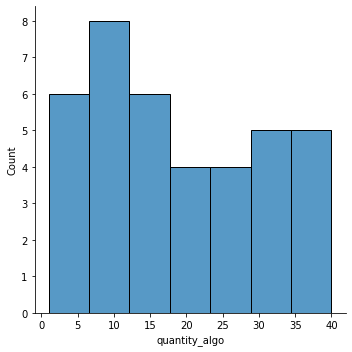

In [114]:
sns.displot(x='quantity_algo', data=missed_fills)

In [111]:
missed_fills.loc[(missed_fills['price_mkt'] != missed_fills['price_algo'])]

,note,price_algo,quantity_algo,side,symbol,timestamp,fill_qty,price_mkt,quantity_mkt,bid,ask,bid_sz,ask_sz,mid_price
9,P2,4893,40,1,BANANAS,4000,0.0,4892.0,1,4891.0,4898.0,30,31,4894.5
18,P1,4899,31,-1,BANANAS,15100,0.0,4898.0,3,4894.0,4900.0,21,1,4897.0
29,P2,4897,31,-1,BANANAS,22900,0.0,4896.0,1,4891.0,4898.0,22,23,4894.5
99,P1,4899,30,-1,BANANAS,66200,0.0,4898.0,5,4894.0,4900.0,23,1,4897.0
111,P2,4900,35,-1,BANANAS,71000,0.0,4899.0,1,4895.0,4901.0,8,30,4898.0
